# Attribution for recommender system model

In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import scipy.sparse as sp
from torch.utils.data import DataLoader, Dataset
from captum.attr import Saliency, IntegratedGradients
import matplotlib.pyplot as plt

/opt/miniconda3/envs/rec_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# download dataset
# url = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
# !wget -q {url} -O ml-1m.zip
# !unzip -q ml-1m.zip

In [155]:
data_path = "ml-1m/ratings.dat"
movies_path = "ml-1m/movies.dat"
users_path = "ml-1m/users.dat"

data = pd.read_csv(data_path, sep="::", names=["user", "item", "rating", "timestamp"], engine="python")
movies = pd.read_csv(movies_path, sep="::", names=["item", "title", "genres"], engine="python", encoding="ISO-8859-1")
users = pd.read_csv(users_path, sep="::", names=["user", "gender", "age", "occupation", "zip"], engine="python")

In [158]:
# reindex
user_mapping = {old:new for new, old in enumerate(users["user"].unique())}
item_mapping = {old:new for new, old in enumerate(movies["item"].unique())}
data["user"] = data["user"].map(user_mapping)
data["item"] = data["item"].map(item_mapping)
movies["item"] = movies["item"].map(item_mapping)
users["user"] = users["user"].map(user_mapping)

num_users = len(user_mapping)
num_items = len(item_mapping)

In [159]:
data['rating'].values.astype(np.float32)

array([5., 3., 3., ..., 5., 4., 4.], dtype=float32)

In [160]:
# define adjacency matrix
def build_adj_matrix(data, num_users, num_items):
    rows, cols = data['user'].values, data['item'].values
    interactions = data['rating'].values.astype(np.float32)
    adj_matrix = sp.coo_matrix((interactions, (rows, cols + num_users)), 
                               shape=(num_users+num_items, num_users+num_items))
    adj_matrix = adj_matrix + adj_matrix.T # make the graph undirected
    return adj_matrix

adj_matrix = build_adj_matrix(data=data, num_users=num_users, num_items=num_items)

def normalize_adj(adj):
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt

adj_matrix = normalize_adj(adj_matrix)
adj_matrix = torch.FloatTensor(adj_matrix.toarray())

/var/folders/5z/8hzvmhln5p36t4tdqc9c52z40000gn/T/ipykernel_88465/1830612108.py:14: RuntimeWarning: divide by zero encountered in power
  d_inv_sqrt = np.power(rowsum, -0.5).flatten()


In [161]:
index_to_occ = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

In [162]:
# Handle user features
gender_map = {'M':0, 'F':1}
users['gender'] = users['gender'].map(gender_map)
# one-hot encode occupation using index_to_occ
occupation = pd.get_dummies(users['occupation'].map(index_to_occ))
users = pd.concat([users, occupation], axis=1)
users.drop(['occupation', 'zip'], axis=1, inplace=True)

In [165]:
users.columns[2:]

Index(['age', 'K-12 student', 'academic/educator', 'artist', 'clerical/admin',
       'college/grad student', 'customer service', 'doctor/health care',
       'executive/managerial', 'farmer', 'homemaker', 'lawyer',
       'other or not specified', 'programmer', 'retired', 'sales/marketing',
       'scientist', 'self-employed', 'technician/engineer',
       'tradesman/craftsman', 'unemployed', 'writer'],
      dtype='object')

In [9]:
user_features = torch.FloatTensor(users.iloc[:, 1:].values.astype(np.float32))

# Handle item features  
genres_set = set('|'.join(movies['genres']).split('|'))
genre_mapping = {genre: i for i, genre in enumerate(genres_set)}
movies['genres_encoded'] = movies['genres'].apply(lambda x: [genre_mapping[g] for g in x.split('|')])
movie_features = torch.zeros((num_items, len(genres_set)))
for i, row in movies.iterrows():
    for g in row['genres_encoded']:
        movie_features[row['item'], g] = 1

In [11]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, n_layers, user_feat_dim, item_feat_dim):
        super(LightGCN, self).__init__()
        # define user and item embeddings
        self.embedding_dim = embedding_dim
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        # project user and item features to the same space as embeddings
        self.user_feat_fc = nn.Linear(user_feat_dim, embedding_dim) 
        self.item_feat_fc = nn.Linear(item_feat_dim, embedding_dim)
        
        self.n_layers = n_layers
        self._init_weights()

    def _init_weights(self):
        # manual xavier initialization
        a = math.sqrt(6 / (1 + self.embedding_dim))
        nn.init.uniform_(self.user_embedding.weight, -a, a)
        nn.init.uniform_(self.item_embedding.weight, -a, a)
        
        nn.init.xavier_uniform_(self.user_feat_fc.weight)
        nn.init.xavier_uniform_(self.item_feat_fc.weight)


    def forward(self, adj, user_features, item_features):
        # standardize user and item features to [0, 1] region
        user_features = (user_features - user_features.mean(dim=0)) / (user_features.std(dim=0) + 1e-8)
        item_features = (item_features - item_features.mean(dim=0)) / (item_features.std(dim=0) + 1e-8)
        
        user_feat_embed = self.user_feat_fc(user_features)
        item_feat_embed = self.item_feat_fc(item_features)
        
        user_combined = torch.layer_norm(self.user_embedding.weight + user_feat_embed, 
                                         [self.embedding_dim])
        item_combined = torch.layer_norm(self.item_embedding.weight + item_feat_embed, 
                                         [self.embedding_dim])
        
        all_embeddings = torch.cat([user_combined, item_combined], dim=0)
        embeddings = [all_embeddings]
        
        for _ in range(self.n_layers):
            all_embeddings = torch.mm(adj, all_embeddings)
            embeddings.append(all_embeddings)
        
        final_embedding = torch.mean(torch.stack(embeddings, dim=0), dim=0)
        user_final, item_final = torch.split(final_embedding, [num_users, num_items])
        return user_final, item_final

model = LightGCN(num_users, num_items, embedding_dim=64, n_layers=3, user_feat_dim=user_features.shape[1], item_feat_dim=len(genres_set))
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss() 

def train(model, data, adj, user_features, item_features, epochs=5):
    
    model.train()
    for epoch in range(epochs):
        user_embed, item_embed = model(adj, user_features, item_features)
        loss = 0
        for user, item, rating in zip(data['user'], data['item'], data['rating']):
            user_vec = user_embed[user]
            item_vec = item_embed[item]
            score = torch.sum(user_vec * item_vec)
            loss += criterion(score, torch.tensor(float(rating)))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
        
train(model, data, adj_matrix, user_features, movie_features, epochs=5)
torch.save(model.state_dict(), "lightgcn.pth")
# model.load_state_dict(torch.load("lightgcn.pth"))
# model.eval()

Epoch 1/5, Loss: -6161508.0000
Epoch 2/5, Loss: -10024034.0000
Epoch 3/5, Loss: -14938030.0000
Epoch 4/5, Loss: -20829508.0000
Epoch 5/5, Loss: -27625436.0000


In [105]:
target_user = 0
target_item = 0

def predict_target(user_feat_batch, movie_feat_batch, 
                   target_user, target_item, 
                   user_features=user_features, 
                   movie_features=movie_features, 
                   model=model):
    # '''
    # Could remove target_user and target_item
    # '''
    outputs = []
    
    B = user_feat_batch.shape[0]
    
    for i in range(B):

        cur_user_feat = user_feat_batch[i]      # [user_feat_dim]
        cur_movie_feat = movie_feat_batch[i]    # [item_feat_dim]
        
        user_features_modified = user_features.clone()
        movie_features_modified = movie_features.clone()
        
        # get the current user and movie features
        
        user_features_modified[target_user] = cur_user_feat
        movie_features_modified[target_item] = cur_movie_feat
        
        # Calculate embeddings and score
        user_embed, movie_embed = model(adj_matrix, user_features_modified, movie_features_modified)
        score = torch.sum(user_embed[target_user] * movie_embed[target_item])
        outputs.append(score)
    
    return torch.stack(outputs)

def wrapped_predict(user_feat, movie_feat, target_user, target_item):
    # print(user_feat.shape)
    return predict_target(user_feat, movie_feat, target_user, target_item)

# target_user_feat = user_features[target_user].unsqueeze(0)
# target_movie_feat = movie_features[target_item].unsqueeze(0)

# baseline_user_feat = torch.zeros_like(target_user_feat)
# baseline_movie_feat = torch.zeros_like(target_movie_feat)

# ig = IntegratedGradients(wrapped_predict)
# attributions, delta = ig.attribute(
#     inputs =  (target_user_feat, target_movie_feat),
#     baselines = (baseline_user_feat, baseline_movie_feat),
#     return_convergence_delta=True
# )

# attributions

def get_attribution(target_user, target_item, 
                    user_features=user_features, 
                    movie_features=movie_features, 
                    model=model):
    target_user_feat = user_features[target_user].unsqueeze(0)
    target_movie_feat = movie_features[target_item].unsqueeze(0)
    
    # print(target_user)
    
    # target_user_tensor = torch.tensor([target_user])
    # target_item_tensor = torch.tensor([target_item])
    
    # print(target_user_tensor.shape)
    
    #use average user and movie features as baseline
    baseline_user_feat = torch.mean(user_features, dim=0).unsqueeze(0)
    baseline_movie_feat = torch.mean(movie_features, dim=0).unsqueeze(0)
    
    ig = IntegratedGradients(wrapped_predict)
    attributions, delta = ig.attribute(
        inputs =  (target_user_feat, target_movie_feat),
        baselines = (baseline_user_feat, baseline_movie_feat),
        additional_forward_args = (target_user, target_item),
        return_convergence_delta=True
    )
    return attributions

In [122]:
users.iloc[4, 3:]
np.where(users.iloc[4, 3:] == 1)[0][0]

20

In [125]:
['gender', 'age'] + ["writer"]

['gender', 'age', 'writer']

In [173]:
index_to_genre = {v: k for k, v in genre_mapping.items()}
index_to_occ = users.columns[3:]

def plot_attribution(attributions, user_index, top=3):
    user_attr, movie_attr = attributions
    user_attr = user_attr.detach().numpy().reshape(-1)
    movie_attr = movie_attr.detach().numpy().reshape(-1)
    user_attr = np.abs(user_attr)
    movie_attr = np.abs(movie_attr)
    occ_attr = user_attr[-len(index_to_occ):]
    
    user_occ = users.iloc[user_index, 3:].values
    user_occ_index = np.where(user_occ == 1)[0][0]
    
    # top_occ_indices = np.argsort(occ_attr)[-1:]
    # print(top_occ_indices)
    # print(occ_attr)
    top_occ_values = occ_attr[user_occ_index]
    # top_user_values = np.concatenate([user_attr[:-len(index_to_occ)], top_occ_values])
    top_occ_labels = index_to_occ[user_occ_index]
    print(user_occ_index)
    print(top_occ_labels)
    top_user_values = np.append(user_attr[:-len(index_to_occ)], top_occ_values)
    user_labels = ['gender', 'age'] + [top_occ_labels]
    
    # print(len(user_labels))
    # print(top_user_values.shape)
    # # Get top user features
    # top_user_indices = np.argsort(user_attr)[-top:]
    # top_user_values = user_attr[top_user_indices]
    # top_user_labels = [index_to_occ[i] for i in top_user_indices]
    
    # Get top movie features
    
    top_movie_indices = np.argsort(movie_attr)[-top:]
    top_movie_values = movie_attr[top_movie_indices]
    top_movie_labels = [index_to_genre[i] for i in top_movie_indices]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].bar(user_labels, top_user_values, color = 'skyblue')
    ax[0].set_xlabel("User Features")
    ax[0].set_ylabel("Attribution")
    ax[0].set_title("Attribution of User Features")
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)
    ax[1].bar(top_movie_labels, top_movie_values, color = 'salmon')
    ax[1].set_xlabel("Movie Features")
    ax[1].set_ylabel("Attribution")
    ax[1].set_title("Top 3 Important Movie Genre Features")
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

The result could be highly confounded.

In [ ]:
# map index back to discriptions
index_to_occ = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

index_to_genre = {v: k for k, v in genre_mapping.items()}
index_to_genre

{0: 'Adventure',
 1: 'Documentary',
 2: 'Musical',
 3: 'Comedy',
 4: 'Thriller',
 5: 'Mystery',
 6: 'Western',
 7: 'Horror',
 8: 'Film-Noir',
 9: "Children's",
 10: 'Drama',
 11: 'Action',
 12: 'Animation',
 13: 'Sci-Fi',
 14: 'Crime',
 15: 'Romance',
 16: 'Fantasy',
 17: 'War'}

In [174]:
def find_top_5(user_index):
    user_embed, item_embed = model(adj_matrix, user_features, movie_features)
    scores = torch.matmul(user_embed[user_index], item_embed.T)
    top5_scores, top5_indices = torch.topk(scores, 5)
    top5_indices = top5_indices.numpy()
    top5_scores = top5_scores.detach().numpy()
    
    for i, (score, idx) in enumerate(zip(top5_scores, top5_indices)):
        movie = movies.iloc[idx]
        print
        print(f"Top {i+1} Recommendation")
        print(f"Title: {movie['title']}")
        print(f"Genres: {movie['genres']}")
        print(f"Score: {score:.4f}")
        print(f"Moview index: {idx}")
        print("\n")
       
    return top5_indices 
        
user_index = 0
top5_indices = find_top_5(user_index)

Top 1 Recommendation
Title: Toy Story 2 (1999)
Genres: Animation|Children's|Comedy
Score: 4.0938
Moview index: 3045


Top 2 Recommendation
Title: Toy Story (1995)
Genres: Animation|Children's|Comedy
Score: 4.0151
Moview index: 0


Top 3 Recommendation
Title: Bug's Life, A (1998)
Genres: Animation|Children's|Comedy
Score: 3.8222
Moview index: 2286


Top 4 Recommendation
Title: South Park: Bigger, Longer and Uncut (1999)
Genres: Animation|Comedy
Score: 3.5999
Moview index: 2631


Top 5 Recommendation
Title: Election (1999)
Genres: Comedy
Score: 3.4522
Moview index: 2530




In [ ]:
item_index = top5_indices[0]
attributions = get_attribution(target_user=user_index, target_item=item_index)

0
K-12 student


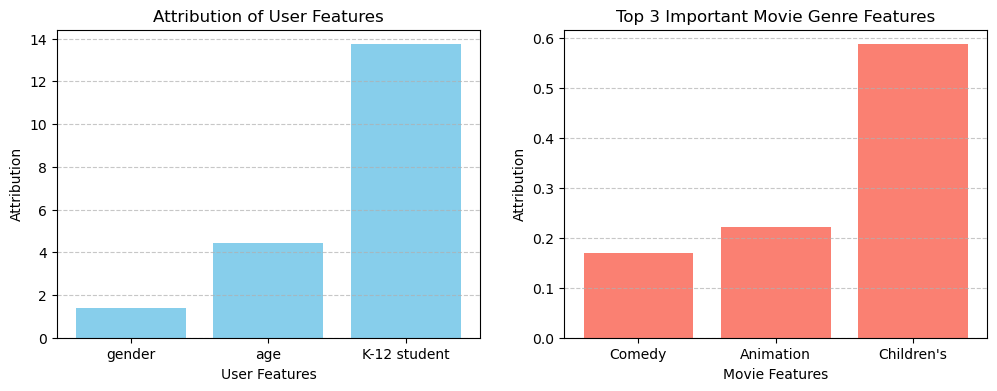

In [175]:
plot_attribution(attributions, user_index, top=3)

In [179]:
users.iloc[3, 3:]

K-12 student              False
academic/educator         False
artist                    False
clerical/admin            False
college/grad student      False
customer service          False
doctor/health care        False
executive/managerial       True
farmer                    False
homemaker                 False
lawyer                    False
other or not specified    False
programmer                False
retired                   False
sales/marketing           False
scientist                 False
self-employed             False
technician/engineer       False
tradesman/craftsman       False
unemployed                False
writer                    False
Name: 3, dtype: object

In [180]:
user_index = 3 # A middle-aged executive/managerial
top5_indices = find_top_5(user_index)

Top 1 Recommendation
Title: American Beauty (1999)
Genres: Comedy|Drama
Score: 20.1400
Moview index: 2789


Top 2 Recommendation
Title: Terminator 2: Judgment Day (1991)
Genres: Action|Sci-Fi|Thriller
Score: 17.6009
Moview index: 585


Top 3 Recommendation
Title: Matrix, The (1999)
Genres: Action|Sci-Fi|Thriller
Score: 17.0791
Moview index: 2502


Top 4 Recommendation
Title: Raiders of the Lost Ark (1981)
Genres: Action|Adventure
Score: 16.8533
Moview index: 1180


Top 5 Recommendation
Title: Star Wars: Episode IV - A New Hope (1977)
Genres: Action|Adventure|Fantasy|Sci-Fi
Score: 16.5983
Moview index: 257




7
executive/managerial


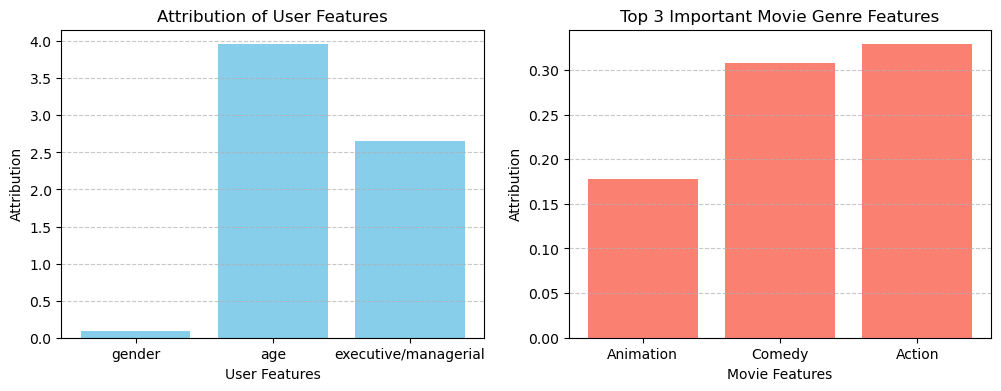

In [182]:
item_index = top5_indices[0]
attributions = get_attribution(target_user=user_index, target_item=item_index)
plot_attribution(attributions, user_index=user_index)

In [199]:
target_user = 4 # a young writer

# find movies with genres 'Drama' and 'Fantasy'
selected_movies = movies[movies['genres'].str.contains('Drama') & movies['genres'].str.contains('Fantasy')]
selected_movies
selected_movie_index = selected_movies['item'].values[:3]
selected_movie_index

attributions_per_movie = {}
for movie in selected_movie_index:
    attributions = get_attribution(target_user=target_user, target_item=movie)
    attributions_per_movie[movie] = {
        "user_attr": attributions[0].detach().numpy(),
        "movie_attr": attributions[1].detach().numpy()
    }

In [202]:
movies.iloc[selected_movie_index]

,item,title,genres
244,244,Heavenly Creatures (1994),Drama|Fantasy|Romance|Thriller
873,873,Bogus (1996),Children's|Drama|Fantasy
1081,1081,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi


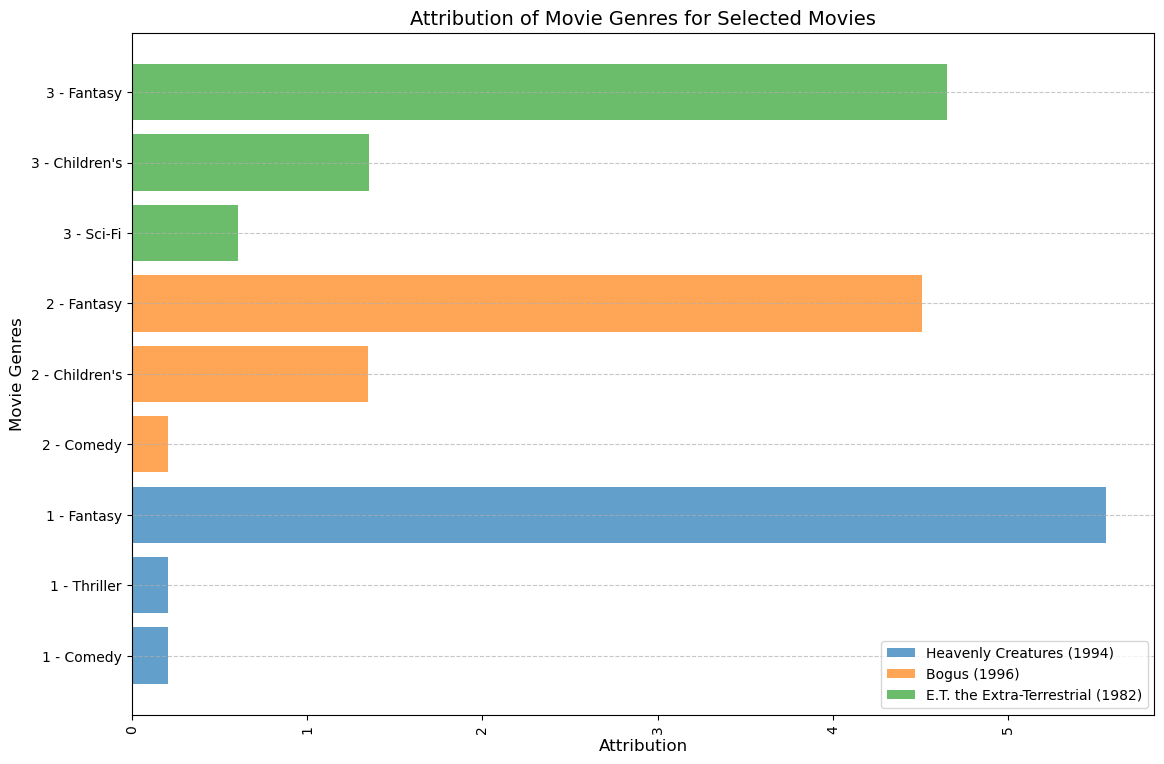

In [214]:
fig, ax = plt.subplots(figsize=(12, 8))

for i, movie in enumerate(selected_movie_index):
    movie_attr = attributions_per_movie[movie]['movie_attr'].flatten()
    movie_attr = np.abs(movie_attr)
    top_genre_indices = np.argsort(movie_attr)[-3:]
    top_genre_values = movie_attr[top_genre_indices]
    top_genre_labels = [index_to_genre[idx] for idx in top_genre_indices]
    ax.barh([f"{i+1} - {label}" for label in top_genre_labels], 
        top_genre_values, label=f"{movies[movies['item'] == movie]['title'].values[0]}", alpha=0.7)

ax.set_xlabel("Attribution", fontsize=12)
ax.set_ylabel("Movie Genres", fontsize=12)
ax.set_title("Attribution of Movie Genres for Selected Movies", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', labelsize=10, rotation=90)
ax.tick_params(axis='y', labelsize=10)
ax.legend()

plt.tight_layout(pad=2.0)
plt.show()


In [ ]:
attributions_per_movie = {}

for movie in selected_movies:
    attributions = get_attribution(target_user, movie)
    attributions_per_movie[movie] = {
        "user_attr": attributions[0].detach().numpy(),
        "movie_attr": attributions[1].detach().numpy()
    }


{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}